<a href="https://colab.research.google.com/github/raveesharanamukage/Basic-Deep-Learning-Projects/blob/main/Total%20Revenue%20Forecast/Total_XGBoost_RC5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction
About the Project
+ This project is a hotel revenue forecasting using ML with giving valuable insights to the client.


About this Notebook
+ This notebook forecast revenue for RevenueCentre_5 perday using XGBoost Regressor Model.


### Import Dataset & Librararies

In [ ]:
#Import necessary Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#column_names=['Date','MealPeriod','RevenueCentreName','CheckTotal']
dataset=pd.read_csv('/content/drive/MyDrive/Datasets/hotel/Total RC datasets/RevenueCenter_5.csv',parse_dates=['Date'])
print(dataset.head())
print(dataset.info()) #Consice summary of the DataFrame
print(dataset.describe())

        Date RevenueCentreName  CheckTotal
0 2023-01-01   RevenueCenter_5     26617.0
1 2023-01-02   RevenueCenter_5     23593.0
2 2023-01-03   RevenueCenter_5     22907.5
3 2023-01-04   RevenueCenter_5     22376.5
4 2023-01-05   RevenueCenter_5     24896.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               486 non-null    datetime64[ns]
 1   RevenueCentreName  486 non-null    object        
 2   CheckTotal         486 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 11.5+ KB
None
                                Date    CheckTotal
count                            486    486.000000
mean   2023-08-31 11:59:59.999999744  26155.364486
min              2023-01-01 00:00:00   9032.000000
25%              2023-05-02 06:00:00  18705.275000
50%              2023-08-31 12:

In [ ]:

dates=pd.date_range(start='2023-01-01',end='2024-04-30',freq='D')
data=dataset.copy()
#Generate full date range
dates = pd.date_range(start='2023-01-01', end='2024-04-30', freq='D')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

#Reindex with the full date range
df = data.reindex(dates)

#Rename index to 'Date' to make it clear
df.index.name = 'Date'

#Linear interpolation
df['CheckTotal'] = df['CheckTotal'].interpolate()

df = df.reset_index()
df.head()


,Date,RevenueCentreName,CheckTotal
0,2023-01-01,RevenueCenter_5,26617.0
1,2023-01-02,RevenueCenter_5,23593.0
2,2023-01-03,RevenueCenter_5,22907.5
3,2023-01-04,RevenueCenter_5,22376.5
4,2023-01-05,RevenueCenter_5,24896.0


In [ ]:
#Single row of Dataset
df.index.dtype
stamp = df.index[5]
df.loc[stamp]

,5
Date,2023-01-06 00:00:00
RevenueCentreName,RevenueCenter_5
CheckTotal,43287.8


### EDA

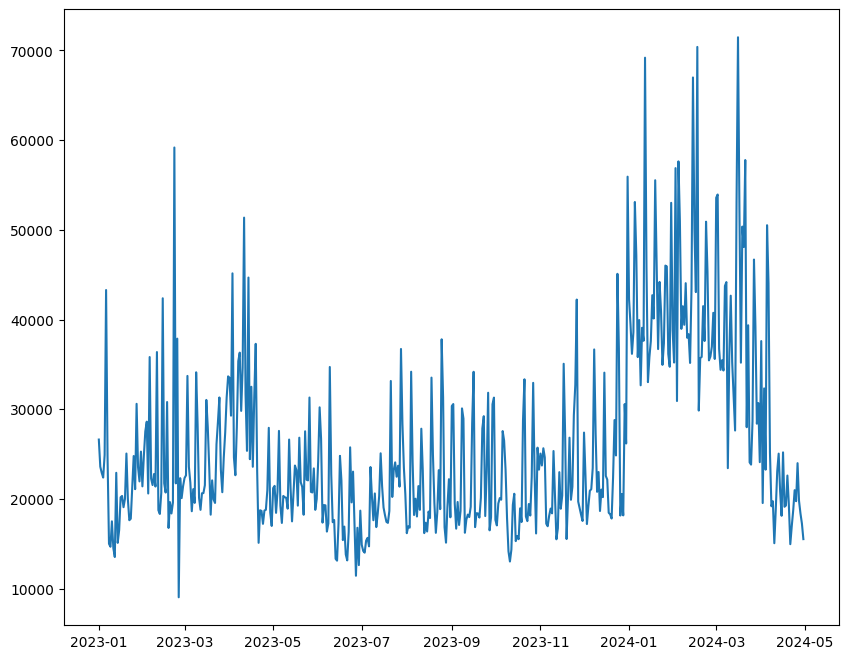

In [ ]:
#Visualize the revenue without considering meal period,revenue centre
plt.figure(figsize=(10,8))
plt.plot(df['Date'],df['CheckTotal'])
plt.show()

In [ ]:
df_break1=pd.DataFrame(dates,columns=['Date'])
df_break1['CheckTotal']=df['CheckTotal']
df_break1

,Date,CheckTotal
0,2023-01-01,26617.0
1,2023-01-02,23593.0
2,2023-01-03,22907.5
3,2023-01-04,22376.5
4,2023-01-05,24896.0
...,...,...
481,2024-04-26,23983.5
482,2024-04-27,19794.0
483,2024-04-28,18381.0
484,2024-04-29,17250.7


+ address the missing date

In [ ]:

df_break1.set_index('Date',inplace=True,drop=True)


In [ ]:
df_break1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 486 entries, 2023-01-01 to 2024-04-30
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CheckTotal  486 non-null    float64
dtypes: float64(1)
memory usage: 7.6 KB


### Train XGBOOST Model


#### Data Preprocessing & Feature Selection
+ Feature Creation
+ Create the Tabular data


In [ ]:
import holidays

# Define UAE holidays
uae_holidays = holidays.UnitedArabEmirates()
df_break1['IsHoliday'] = df_break1.index.map(lambda x: 1 if x in uae_holidays else 0)

# Add seasonal feature for Dubai's peak tourist months
df_break1['IsPeakSeason'] = df_break1.index.month.isin([11, 12, 1, 2, 3]).astype(int)

#make this a function for all datasets
df_break1['DayofWeek']=df_break1.index.day_of_week
df_break1['DayofMonth']=df_break1.index.day
df_break1['Month']=df_break1.index.month

df_break1['rolling_mean_3'] = df_break1['CheckTotal'].rolling(window=7).mean()
df_break1['is_weekend'] = df_break1.index.dayofweek >= 5

df_break1['Lag1']=df_break1['CheckTotal'].shift(1)
df_break1['Lag2']=df_break1['CheckTotal'].shift(2)
df_break1['Lag3']=df_break1['CheckTotal'].shift(3)
df_break1['Lag4']=df_break1['CheckTotal'].shift(4)
df_break1.dropna(inplace=True)

### Visualize Feature/Target Relationship

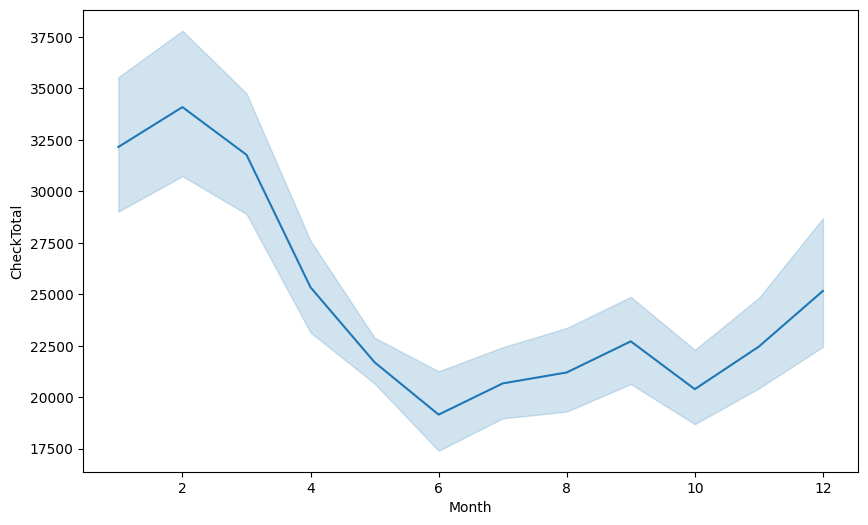

In [ ]:
#Line Plot
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(df_break1,x='Month',y='CheckTotal',)
plt.show()

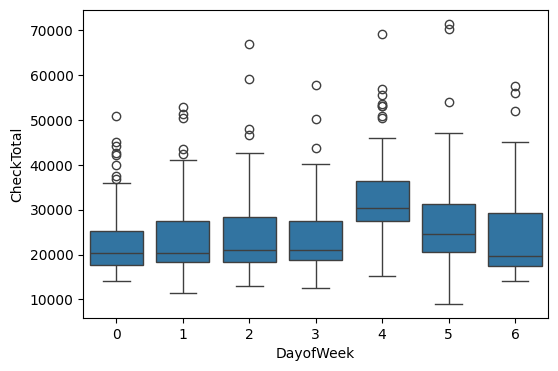

In [ ]:
#Box plot
plt.figure(figsize=(6,4))
sns.boxplot(df_break1,x='DayofWeek',y='CheckTotal')
plt.show()

In [ ]:
#Feature Correlation
df_numeric=df_break1.select_dtypes(include=[np.number])
corr_matrix=df_numeric.corr()


In [ ]:
corr_matrix

,CheckTotal,IsHoliday,IsPeakSeason,DayofWeek,DayofMonth,Month,rolling_mean_3,Lag1,Lag2,Lag3,Lag4
CheckTotal,1.000000,-0.093910,0.395605,0.113426,-0.035072,-0.371222,0.770103,0.625948,0.530120,0.508471,0.504541
IsHoliday,-0.093910,1.000000,-0.114167,0.021314,0.007112,0.021425,-0.043934,-0.088396,-0.077243,-0.018433,-0.009526
IsPeakSeason,0.395605,-0.114167,1.000000,0.010391,0.011413,-0.308973,0.486598,0.393016,0.387322,0.379882,0.372122
DayofWeek,0.113426,0.021314,0.010391,1.000000,-0.006546,0.013698,0.000695,0.212789,0.118085,-0.225319,-0.140073
DayofMonth,-0.035072,0.007112,0.011413,-0.006546,1.000000,-0.012373,-0.030598,-0.038681,-0.038742,-0.020028,0.011602
Month,-0.371222,0.021425,-0.308973,0.013698,-0.012373,1.000000,-0.500338,-0.395949,-0.396443,-0.400543,-0.397333
rolling_mean_3,0.770103,-0.043934,0.486598,0.000695,-0.030598,-0.500338,1.000000,0.784552,0.787982,0.788278,0.787412
Lag1,0.625948,-0.088396,0.393016,0.212789,-0.038681,-0.395949,0.784552,1.000000,0.623144,0.526659,0.505408
Lag2,0.530120,-0.077243,0.387322,0.118085,-0.038742,-0.396443,0.787982,0.623144,1.000000,0.622653,0.526197
Lag3,0.508471,-0.018433,0.379882,-0.225319,-0.020028,-0.400543,0.788278,0.526659,0.622653,1.000000,0.622396


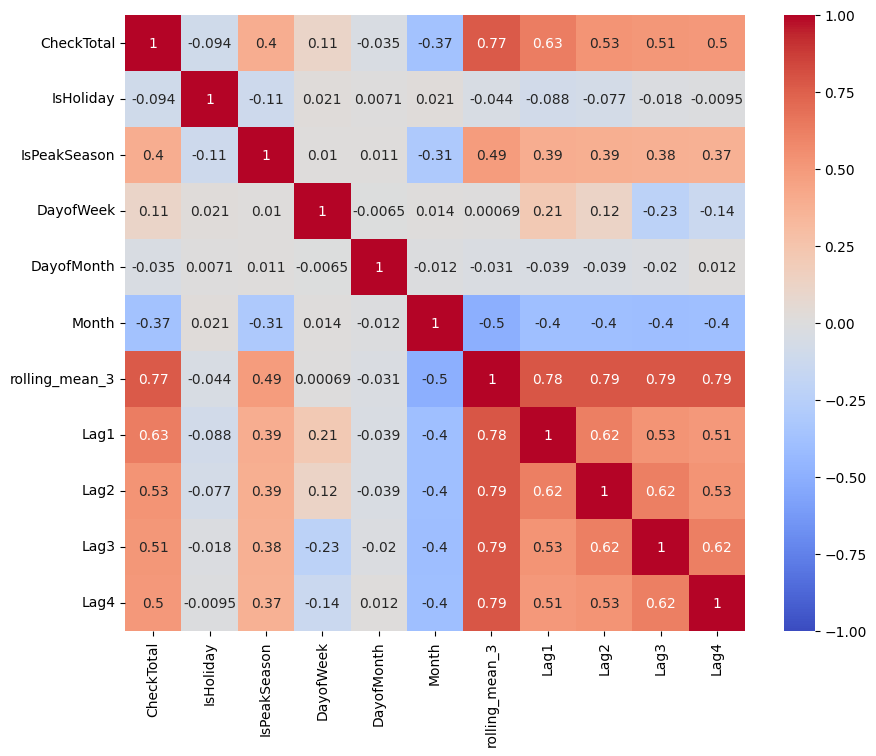

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,cmap='coolwarm',annot=True,vmin=-1,vmax=1,)
plt.show()


#### Model Train

In [ ]:
df_break1.columns

Index(['CheckTotal', 'IsHoliday', 'IsPeakSeason', 'DayofWeek', 'DayofMonth',
       'Month', 'rolling_mean_3', 'is_weekend', 'Lag1', 'Lag2', 'Lag3',
       'Lag4'],
      dtype='object')

In [ ]:
df_break1

,CheckTotal,IsHoliday,IsPeakSeason,DayofWeek,DayofMonth,Month,rolling_mean_3,is_weekend,Lag1,Lag2,Lag3,Lag4
Date,,,,,,,,,,,,
2023-01-07,24670.00,0,1,5,7,1,26906.828571,True,43287.80,24896.00,22376.5,22907.5
2023-01-08,14998.00,0,1,6,8,1,25246.971429,True,24670.00,43287.80,24896.0,22376.5
2023-01-09,14665.75,0,1,0,9,1,23971.650000,False,14998.00,24670.00,43287.8,24896.0
2023-01-10,17499.50,0,1,1,10,1,23199.078571,False,14665.75,14998.00,24670.0,43287.8
2023-01-11,14504.00,0,1,2,11,1,22074.435714,False,17499.50,14665.75,14998.0,24670.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,23983.50,0,0,4,26,4,19241.857143,False,19745.20,20972.00,18713.6,16942.0
2024-04-27,19794.00,0,0,5,27,4,19300.314286,True,23983.50,19745.20,20972.0,18713.6
2024-04-28,18381.00,0,0,6,28,4,19790.185714,True,19794.00,23983.50,19745.2,20972.0


In [ ]:
Features=['DayofWeek',
       'DayofMonth', 'Month','Lag1', 'Lag2','Lag3', 'Lag4','rolling_mean_3', 'is_weekend','IsHoliday', 'IsPeakSeason']
Target=['CheckTotal']

In [ ]:
#Train Test Split
from sklearn.model_selection import train_test_split
import numpy as np
X=df_break1[Features]
y=df_break1[Target]

X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.9,shuffle=False)


In [ ]:
X_train.shape,y_test.shape


((432, 11), (48, 1))

In [ ]:
X_train.shape[0]


432

In [ ]:
#Train the Model
import xgboost as xgb
from sklearn.metrics import mean_squared_error

reg=xgb.XGBRegressor(n_estimator=100,learning_rate=0.05,max_depth=6)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=5)


[0]	validation_0-rmse:9749.03951	validation_1-rmse:13263.64487
[5]	validation_0-rmse:8048.50414	validation_1-rmse:11959.54163
[10]	validation_0-rmse:6759.42746	validation_1-rmse:11049.59844
[15]	validation_0-rmse:5737.20822	validation_1-rmse:10364.70620
[20]	validation_0-rmse:4931.68787	validation_1-rmse:9903.86367
[25]	validation_0-rmse:4256.64952	validation_1-rmse:9742.13555
[30]	validation_0-rmse:3757.31733	validation_1-rmse:9680.90871
[35]	validation_0-rmse:3336.59591	validation_1-rmse:9587.68724
[40]	validation_0-rmse:2994.64799	validation_1-rmse:9602.59811
[45]	validation_0-rmse:2691.56343	validation_1-rmse:9495.72347
[50]	validation_0-rmse:2460.30332	validation_1-rmse:9436.92674
[55]	validation_0-rmse:2257.92716	validation_1-rmse:9422.65926
[60]	validation_0-rmse:2113.41072	validation_1-rmse:9439.22926
[65]	validation_0-rmse:1966.37838	validation_1-rmse:9454.01953
[70]	validation_0-rmse:1853.27034	validation_1-rmse:9440.57739
[75]	validation_0-rmse:1757.15245	validation_1-rmse:9

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:25:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


[85]	validation_0-rmse:1586.52370	validation_1-rmse:9400.99410
[90]	validation_0-rmse:1532.09362	validation_1-rmse:9362.64415
[95]	validation_0-rmse:1460.00132	validation_1-rmse:9327.99504
[99]	validation_0-rmse:1410.44401	validation_1-rmse:9315.65592


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimator=100, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['Importance'])

,Importance
DayofWeek,0.065714
DayofMonth,0.021257
Month,0.040117
Lag1,0.030884
Lag2,0.036664
Lag3,0.039376
Lag4,0.043321
rolling_mean_3,0.482624
is_weekend,0.000000
IsHoliday,0.047029


In [ ]:
test=df_break1[X_train.shape[0]:]
test['Prediction']=reg.predict(test[Features])


/tmp/ipython-input-63-37185756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction']=reg.predict(test[Features])


In [ ]:
df_break1.merge(test[['Prediction']],how='left',left_index=True,right_index=True)

,CheckTotal,IsHoliday,IsPeakSeason,DayofWeek,DayofMonth,Month,rolling_mean_3,is_weekend,Lag1,Lag2,Lag3,Lag4,Prediction
Date,,,,,,,,,,,,,
2023-01-07,24670.00,0,1,5,7,1,26906.828571,True,43287.80,24896.00,22376.5,22907.5,NaN
2023-01-08,14998.00,0,1,6,8,1,25246.971429,True,24670.00,43287.80,24896.0,22376.5,NaN
2023-01-09,14665.75,0,1,0,9,1,23971.650000,False,14998.00,24670.00,43287.8,24896.0,NaN
2023-01-10,17499.50,0,1,1,10,1,23199.078571,False,14665.75,14998.00,24670.0,43287.8,NaN
2023-01-11,14504.00,0,1,2,11,1,22074.435714,False,17499.50,14665.75,14998.0,24670.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,23983.50,0,0,4,26,4,19241.857143,False,19745.20,20972.00,18713.6,16942.0,25384.382812
2024-04-27,19794.00,0,0,5,27,4,19300.314286,True,23983.50,19745.20,20972.0,18713.6,19653.279297
2024-04-28,18381.00,0,0,6,28,4,19790.185714,True,19794.00,23983.50,19745.2,20972.0,18235.306641


## Model Validate and Forecast

#### Model Validate

In [ ]:
df_break1

,CheckTotal,IsHoliday,IsPeakSeason,DayofWeek,DayofMonth,Month,rolling_mean_3,is_weekend,Lag1,Lag2,Lag3,Lag4
Date,,,,,,,,,,,,
2023-01-07,24670.00,0,1,5,7,1,26906.828571,True,43287.80,24896.00,22376.5,22907.5
2023-01-08,14998.00,0,1,6,8,1,25246.971429,True,24670.00,43287.80,24896.0,22376.5
2023-01-09,14665.75,0,1,0,9,1,23971.650000,False,14998.00,24670.00,43287.8,24896.0
2023-01-10,17499.50,0,1,1,10,1,23199.078571,False,14665.75,14998.00,24670.0,43287.8
2023-01-11,14504.00,0,1,2,11,1,22074.435714,False,17499.50,14665.75,14998.0,24670.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,23983.50,0,0,4,26,4,19241.857143,False,19745.20,20972.00,18713.6,16942.0
2024-04-27,19794.00,0,0,5,27,4,19300.314286,True,23983.50,19745.20,20972.0,18713.6
2024-04-28,18381.00,0,0,6,28,4,19790.185714,True,19794.00,23983.50,19745.2,20972.0


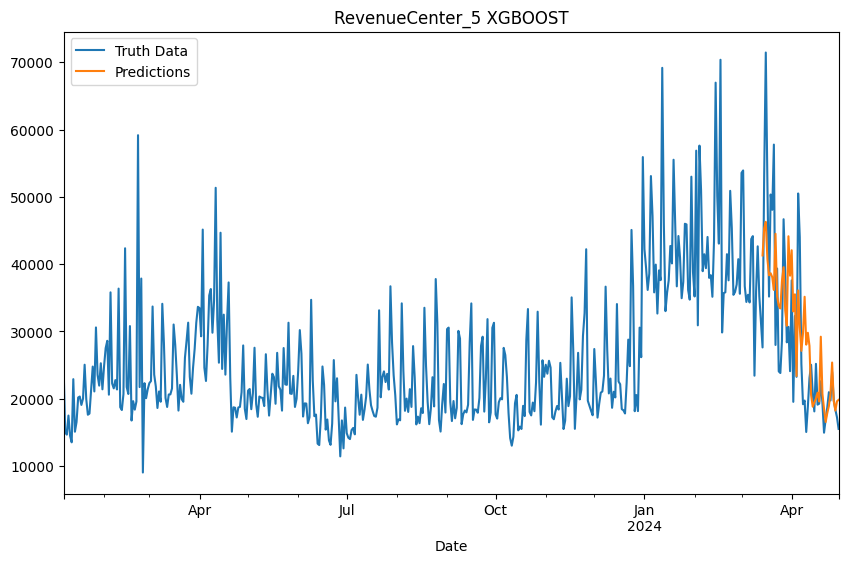

In [ ]:
ax=df_break1[['CheckTotal']].plot(figsize=(10,6))
test['Prediction'].plot(ax=ax,style='-')

name=f'{df["RevenueCentreName"][0]} XGBOOST'
plt.title(name)
plt.legend(['Truth Data','Predictions'])
plt.show()

In [ ]:
type(X_test),type(y_test),X_test.shape,y_test.shape

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame, (48, 11), (48, 1))

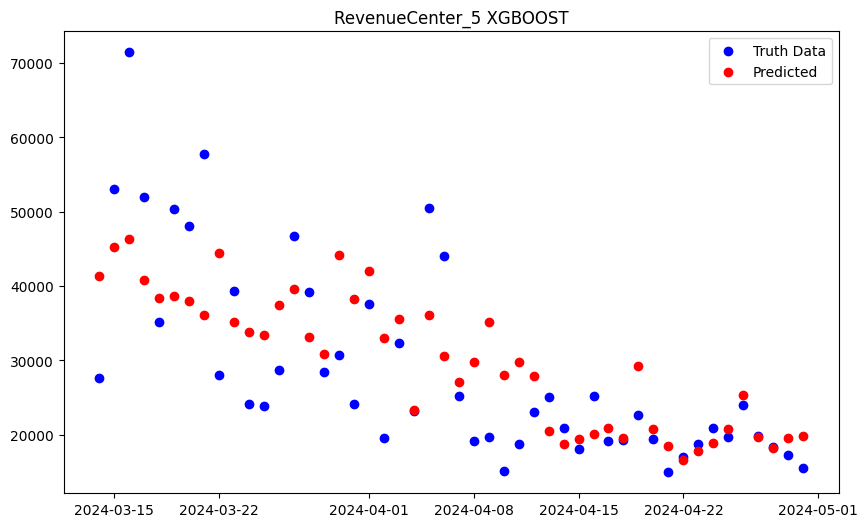

In [ ]:
plt.figure(num=2,figsize=(10,6))
plt.scatter(test.index,test['CheckTotal'],label='Truth Data',c='b')
plt.scatter(test.index,test['Prediction'],label='Predicted',c='r')
name=f'{df["RevenueCentreName"][0]} XGBOOST'
plt.title(name)
plt.legend()
plt.show()

In [ ]:
# Create future dates for 90 days
test_dates = X_test.index
test_dates
#future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='D')

# Initialize future dataframe
test_fc = pd.DataFrame(index=test_dates)
test_fc['DayofWeek'] = test_fc.index.dayofweek
test_fc['DayofMonth'] = test_fc.index.day
test_fc['Month'] = test_fc.index.month
test_fc['is_weekend'] = test_fc.index.dayofweek >= 5
test_fc['IsHoliday'] = test_fc.index.map(lambda x: 1 if x in uae_holidays else 0)
test_fc['IsPeakSeason'] = test_fc.index.month.isin([11, 12, 1, 2, 3]).astype(int)

# Initialize lag and rolling features
future_test_predictions = []
last_4_days = df['CheckTotal'].tail(4).tolist()  # For Lag1 to Lag4
last_3_days = df['CheckTotal'].tail(3).tolist()  # For rolling_mean_3

In [ ]:
features=['DayofWeek',
       'DayofMonth', 'Month','Lag1', 'Lag2','Lag3', 'Lag4','rolling_mean_3', 'is_weekend','IsHoliday', 'IsPeakSeason']
Target=['CheckTotal']
# Iteratively predict each day
for i in range(X_test.shape[0]):
    current_features = test_fc.iloc[i:i+1][['DayofWeek', 'DayofMonth', 'Month',
                                             'is_weekend', 'IsHoliday', 'IsPeakSeason']].copy()
    current_features['Lag1'] = last_4_days[-1] if i == 0 else future_test_predictions[-1]
    current_features['Lag2'] = last_4_days[-2] if i <= 1 else future_test_predictions[-2]
    current_features['Lag3'] = last_4_days[-3] if i <= 2 else future_test_predictions[-3]
    current_features['Lag4'] = last_4_days[-4] if i <= 3 else future_test_predictions[-4]
    rolling_data_3 = last_3_days[-3:] if i == 0 else (last_3_days[-3+i:] + future_test_predictions[:i])[-3:]

    current_features['rolling_mean_3'] = pd.Series(rolling_data_3).mean()


    # Predict revenue
    pred = reg.predict(current_features[features])[0]
    future_test_predictions.append(pred)

    # Update lag and rolling data
    if i < 4:
        last_4_days.append(pred)
    else:
        last_4_days = last_4_days[1:] + [pred]
    if i < 3:
        last_3_days.append(pred)
    else:
        last_3_days = last_3_days[1:] + [pred]

# Create forecast
forecast_test_df = pd.DataFrame({'Date': test_dates, 'Predicted_CheckTotal': future_test_predictions})
print(forecast_test_df.head())

        Date  Predicted_CheckTotal
0 2024-03-14          17180.988281
1 2024-03-15          23000.363281
2 2024-03-16          22793.142578
3 2024-03-17          18545.542969
4 2024-03-18          20395.894531


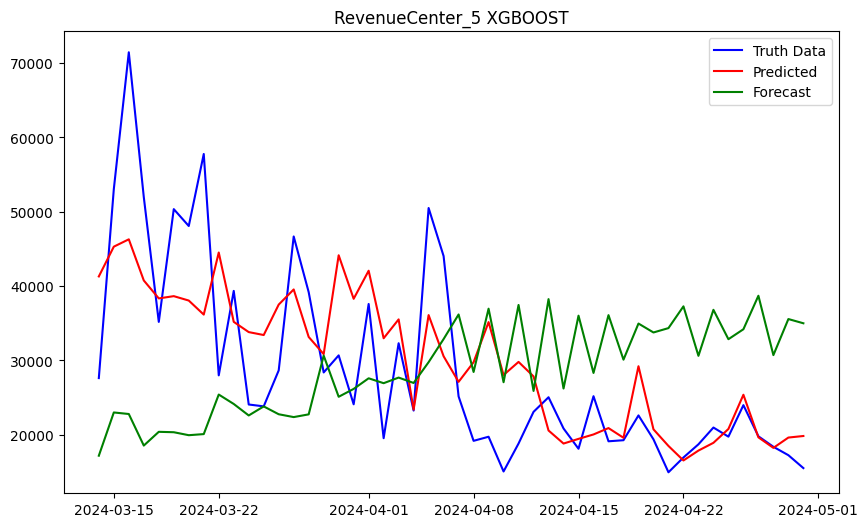

In [ ]:
plt.figure(num=3,figsize=(10,6))
plt.plot(test.index,test['CheckTotal'],label='Truth Data',c='b')
plt.plot(test.index,test['Prediction'],label='Predicted',c='r')
plt.plot(forecast_test_df['Date'],forecast_test_df['Predicted_CheckTotal'],label='Forecast',c='g')
name=f'{df["RevenueCentreName"][0]} XGBOOST'
plt.title(name)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = reg.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

RMSE: 9315.656069220246
MAE: 7117.53369140625
R²: 0.4987778663635254


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = reg.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

RMSE: 9315.656069220246
MAE: 7117.53369140625
R²: 0.4987778663635254


#### Forecast

In [ ]:
# Create future dates for 90 days
last_date = df_break1.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='D')

# Initialize future dataframe
future_df = pd.DataFrame(index=future_dates)
future_df['DayofWeek'] = future_df.index.dayofweek
future_df['DayofMonth'] = future_df.index.day
future_df['Month'] = future_df.index.month
future_df['is_weekend'] = future_df.index.dayofweek >= 5
future_df['IsHoliday'] = future_df.index.map(lambda x: 1 if x in uae_holidays else 0)
future_df['IsPeakSeason'] = future_df.index.month.isin([11, 12, 1, 2, 3]).astype(int)

# Initialize lag and rolling features
future_predictions = []
last_4_days = df['CheckTotal'].tail(4).tolist()  # For Lag1 to Lag4
last_3_days = df['CheckTotal'].tail(3).tolist()  # For rolling_mean_3


features=['DayofWeek',
       'DayofMonth', 'Month','Lag1', 'Lag2','Lag3', 'Lag4','rolling_mean_3', 'is_weekend','IsHoliday', 'IsPeakSeason']
Target=['CheckTotal']
# Iteratively predict each day
for i in range(90):
    current_features = future_df.iloc[i:i+1][['DayofWeek', 'DayofMonth', 'Month',
                                             'is_weekend', 'IsHoliday', 'IsPeakSeason']].copy()
    current_features['Lag1'] = last_4_days[-1] if i == 0 else future_predictions[-1]
    current_features['Lag2'] = last_4_days[-2] if i <= 1 else future_predictions[-2]
    current_features['Lag3'] = last_4_days[-3] if i <= 2 else future_predictions[-3]
    current_features['Lag4'] = last_4_days[-4] if i <= 3 else future_predictions[-4]
    rolling_data_3 = last_3_days[-3:] if i == 0 else (last_3_days[-3+i:] + future_predictions[:i])[-3:]

    current_features['rolling_mean_3'] = pd.Series(rolling_data_3).mean()


    # Predict revenue
    pred = reg.predict(current_features[features])[0]
    future_predictions.append(pred)

    # Update lag and rolling data
    if i < 4:
        last_4_days.append(pred)
    else:
        last_4_days = last_4_days[1:] + [pred]
    if i < 3:
        last_3_days.append(pred)
    else:
        last_3_days = last_3_days[1:] + [pred]

# Create and save forecast
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_CheckTotal': future_predictions})
#forecast_df.to_csv('dubai_breakfast_forecast_3months.csv', index=False)
#print("3-month forecast saved to 'dubai_breakfast_forecast_3months.csv'")
print(forecast_df.head())

        Date  Predicted_CheckTotal
0 2024-05-01          17657.328125
1 2024-05-02          18567.628906
2 2024-05-03          24567.501953
3 2024-05-04          20180.212891
4 2024-05-05          17782.310547


In [ ]:
future_dates

DatetimeIndex(['2024-05-01', '2024-05-02', '2024-05-03', '2024-05-04',
               '2024-05-05', '2024-05-06', '2024-05-07', '2024-05-08',
               '2024-05-09', '2024-05-10', '2024-05-11', '2024-05-12',
               '2024-05-13', '2024-05-14', '2024-05-15', '2024-05-16',
               '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20',
               '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24',
               '2024-05-25', '2024-05-26', '2024-05-27', '2024-05-28',
               '2024-05-29', '2024-05-30', '2024-05-31', '2024-06-01',
               '2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
               '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
               '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
      

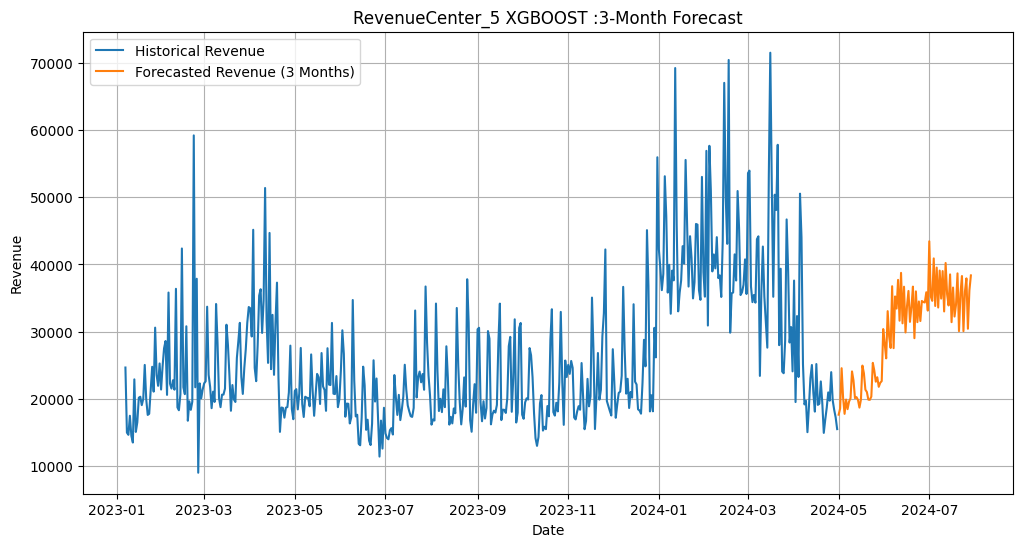

In [ ]:
import matplotlib.pyplot as plt

# Plot historical and forecasted revenue
plt.figure(figsize=(12, 6))
plt.plot(df_break1.index, df_break1['CheckTotal'], label='Historical Revenue', color='#1f77b4')
plt.plot(forecast_df['Date'], forecast_df['Predicted_CheckTotal'], label='Forecasted Revenue (3 Months)', color='#ff7f0e')
name=f'{df["RevenueCentreName"][0]} XGBOOST'
plt.title(f'{name} :3-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

Save the forecast results

In [ ]:
future_da=pd.DataFrame({'Date':forecast_df['Date'], 'Predicted_CheckTotal':forecast_df['Predicted_CheckTotal']})


In [ ]:
file_name=f'{df["RevenueCentreName"][0]} XGBOOST'
future_da.to_csv(f"/content/drive/MyDrive/Datasets/hotel/XGBOOST Forecast/{file_name}.csv",index=False)